In [3]:
import os
import numpy as np
import tensorflow as tf

from tensorflow import keras

In [4]:
import tensorflow as tf

from tensorflow import keras


class VAE(keras.models.Model):
    """
    This VAE uses MSE as a part of the loss function:
    It is typically used for datasets where the data is continuous.
    MSE measures the squared differences between the true and predicted values.
    For the lesions dataset, the images likely consist of continuous pixel intensities,
    making MSE a more appropriate choice.

    Taken from: https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/03_vae/03_vae_faces/vae_faces.ipynb
    """
    def __init__(self, encoder: keras.models.Model, decoder: keras.models.Model, beta: int, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)

        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                self.beta * keras.losses.mean_squared_error(data, reconstruction))
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            self.beta * keras.losses.mean_squared_error(data, reconstruction))
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1))
        total_loss = reconstruction_loss + kl_loss

        return {
            'loss': total_loss,
            'reconstruction_loss': reconstruction_loss,
            'kl_loss': kl_loss,
        }


In [1]:
WIDTH = 160
HEIGHT = 160

In [5]:
data_dir = os.path.join(
    '.',
    'data')
train_data = keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    color_mode='rgb',
    image_size=(HEIGHT, WIDTH),
    batch_size=32,
    shuffle=True,
    seed=42,
    interpolation='bilinear')

Found 717 files belonging to 1 classes.


In [6]:
def preprocess(img):
    img = tf.cast(img, float) / 255.0

    return img


train = train_data.map(lambda x: preprocess(x))

In [25]:
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 100
BETA = 2000
LOAD_MODEL = False

In [8]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
encoder_input = keras.layers.Input(
    shape=(HEIGHT, WIDTH, CHANNELS), name="encoder_input"
)
x = keras.layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
shape_before_flattening = keras.backend.int_shape(x)[1:]  # the decoder will need this!

x = keras.layers.Flatten()(x)
z_mean = keras.layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = keras.layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 64)   1792        ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [10]:
decoder_input = keras.layers.Input(shape=(Z_DIM,), name="decoder_input")
x = keras.layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Reshape(shape_before_flattening)(x)
x = keras.layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
decoder_output = keras.layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = keras.models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 1600)              321600    
                                                                 
 batch_normalization_5 (Batc  (None, 1600)             6400      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1600)              0         
                                                                 
 reshape (Reshape)           (None, 5, 5, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 10, 64)       36928     
 nspose)                                                     

In [22]:
vae = VAE(encoder, decoder, BETA)

In [23]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [26]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(keras.callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [28]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 43.5417 - reconstruction_loss: 29.6302 - kl_loss: 12.8122

23/23 [==============================] - 129s 6s/step - loss: 43.4959 - reconstruction_loss: 29.6302 - kl_loss: 12.8122
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 39.8690 - reconstruction_loss: 28.5715 - kl_loss: 12.0948

23/23 [==============================] - 119s 5s/step - loss: 39.9023 - reconstruction_loss: 28.5715 - kl_loss: 12.0948
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 40.0994 - reconstruction_loss: 27.8461 - kl_loss: 12.6205

23/23 [==============================] - 120s 5s/step - loss: 40.1147 - reconstruction_loss: 27.8461 - kl_loss: 12.6205
Epoch 4/100
23/23 [==============================] - 110s 5s/step - loss: 42.1021 - reconstruction_loss: 28.6079 - kl_loss: 13.0882
Epoch 5/100
23/23 [==============================] - ETA: 0s - loss: 38.9870 - reconstruction_loss: 26.5719 - kl_loss: 12.2383

23/23 [==============================] - 127s 6s/step - loss: 38.9796 - reconstruction_loss: 26.5719 - kl_loss: 12.2383
Epoch 6/100
23/23 [==============================] - ETA: 0s - loss: 36.3536 - reconstruction_loss: 25.6010 - kl_loss: 11.4364

23/23 [==============================] - 117s 5s/step - loss: 36.3821 - reconstruction_loss: 25.6010 - kl_loss: 11.4364
Epoch 7/100
23/23 [==============================] - 110s 5s/step - loss: 40.3665 - reconstruction_loss: 26.4091 - kl_loss: 13.7486
Epoch 8/100
23/23 [==============================] - 110s 5s/step - loss: 40.5900 - reconstruction_loss: 27.0939 - kl_loss: 12.2053
Epoch 9/100
23/23 [==============================] - ETA: 0s - loss: 37.1013 - reconstruction_loss: 25.0342 - kl_loss: 11.6583

23/23 [==============================] - 126s 6s/step - loss: 37.0843 - reconstruction_loss: 25.0342 - kl_loss: 11.6583
Epoch 10/100
23/23 [==============================] - 119s 5s/step - loss: 37.7237 - reconstruction_loss: 26.1959 - kl_loss: 12.4941
Epoch 11/100
23/23 [==============================] - 108s 5s/step - loss: 35.8735 - reconstruction_loss: 25.0020 - kl_loss: 12.1924
Epoch 12/100
23/23 [==============================] - ETA: 0s - loss: 35.8457 - reconstruction_loss: 24.0972 - kl_loss: 12.0031

23/23 [==============================] - 119s 5s/step - loss: 35.8563 - reconstruction_loss: 24.0972 - kl_loss: 12.0031
Epoch 13/100
23/23 [==============================] - ETA: 0s - loss: 34.5725 - reconstruction_loss: 23.9082 - kl_loss: 11.5692

23/23 [==============================] - 118s 5s/step - loss: 34.6102 - reconstruction_loss: 23.9082 - kl_loss: 11.5692
Epoch 14/100
23/23 [==============================] - 110s 5s/step - loss: 35.6801 - reconstruction_loss: 24.4933 - kl_loss: 11.6251
Epoch 15/100
23/23 [==============================] - 120s 5s/step - loss: 36.6071 - reconstruction_loss: 24.2032 - kl_loss: 12.7361
Epoch 16/100
23/23 [==============================] - ETA: 0s - loss: 34.3927 - reconstruction_loss: 22.9979 - kl_loss: 11.8195

23/23 [==============================] - 121s 5s/step - loss: 34.4104 - reconstruction_loss: 22.9979 - kl_loss: 11.8195
Epoch 17/100
23/23 [==============================] - 110s 5s/step - loss: 35.7114 - reconstruction_loss: 24.0101 - kl_loss: 11.4847
Epoch 18/100
23/23 [==============================] - 110s 5s/step - loss: 34.7921 - reconstruction_loss: 23.6283 - kl_loss: 11.5186
Epoch 19/100
23/23 [==============================] - ETA: 0s - loss: 34.8263 - reconstruction_loss: 23.6721 - kl_loss: 11.0581

23/23 [==============================] - 129s 6s/step - loss: 34.8223 - reconstruction_loss: 23.6721 - kl_loss: 11.0581
Epoch 20/100
23/23 [==============================] - 109s 5s/step - loss: 35.0440 - reconstruction_loss: 22.8764 - kl_loss: 12.2958
Epoch 21/100
23/23 [==============================] - ETA: 0s - loss: 31.7700 - reconstruction_loss: 22.7003 - kl_loss: 10.4544

23/23 [==============================] - 119s 5s/step - loss: 31.8277 - reconstruction_loss: 22.7003 - kl_loss: 10.4544
Epoch 22/100
23/23 [==============================] - 111s 5s/step - loss: 33.1033 - reconstruction_loss: 22.2553 - kl_loss: 10.9951
Epoch 23/100
23/23 [==============================] - 109s 5s/step - loss: 33.2606 - reconstruction_loss: 22.8203 - kl_loss: 10.9449
Epoch 24/100
23/23 [==============================] - 121s 5s/step - loss: 35.1867 - reconstruction_loss: 23.9975 - kl_loss: 11.5907
Epoch 25/100
23/23 [==============================] - 111s 5s/step - loss: 32.6828 - reconstruction_loss: 22.3923 - kl_loss: 11.4037
Epoch 26/100
23/23 [==============================] - ETA: 0s - loss: 31.8638 - reconstruction_loss: 21.9149 - kl_loss: 11.0614

23/23 [==============================] - 119s 5s/step - loss: 31.9102 - reconstruction_loss: 21.9149 - kl_loss: 11.0614
Epoch 27/100
23/23 [==============================] - ETA: 0s - loss: 31.2346 - reconstruction_loss: 21.7403 - kl_loss: 10.6783

23/23 [==============================] - 122s 5s/step - loss: 31.2839 - reconstruction_loss: 21.7403 - kl_loss: 10.6783
Epoch 28/100
23/23 [==============================] - ETA: 0s - loss: 31.7681 - reconstruction_loss: 21.8589 - kl_loss: 9.9698

23/23 [==============================] - 120s 5s/step - loss: 31.7706 - reconstruction_loss: 21.8589 - kl_loss: 9.9698
Epoch 29/100
23/23 [==============================] - 109s 5s/step - loss: 34.5552 - reconstruction_loss: 22.0982 - kl_loss: 11.2572
Epoch 30/100
23/23 [==============================] - 110s 5s/step - loss: 31.9932 - reconstruction_loss: 22.5248 - kl_loss: 10.9099
Epoch 31/100
23/23 [==============================] - 110s 5s/step - loss: 32.0722 - reconstruction_loss: 21.6927 - kl_loss: 10.6546
Epoch 32/100
23/23 [==============================] - 109s 5s/step - loss: 33.3765 - reconstruction_loss: 21.5155 - kl_loss: 11.8199
Epoch 33/100
23/23 [==============================] - 111s 5s/step - loss: 33.6800 - reconstruction_loss: 22.0505 - kl_loss: 10.8368
Epoch 34/100
23/23 [==============================] - ETA: 0s - loss: 31.2325 - reconstruction_loss: 20.4958 - kl_loss: 10.8711

23/23 [==============================] - 129s 6s/step - loss: 31.2381 - reconstruction_loss: 20.4958 - kl_loss: 10.8711
Epoch 35/100
23/23 [==============================] - 109s 5s/step - loss: 32.8002 - reconstruction_loss: 21.2794 - kl_loss: 10.8410
Epoch 36/100
23/23 [==============================] - ETA: 0s - loss: 30.4201 - reconstruction_loss: 20.7727 - kl_loss: 10.3525

23/23 [==============================] - 119s 5s/step - loss: 30.4495 - reconstruction_loss: 20.7727 - kl_loss: 10.3525
Epoch 37/100
23/23 [==============================] - 110s 5s/step - loss: 30.5806 - reconstruction_loss: 20.8093 - kl_loss: 10.5205
Epoch 38/100
23/23 [==============================] - 117s 5s/step - loss: 31.3163 - reconstruction_loss: 21.1385 - kl_loss: 10.6082
Epoch 39/100
23/23 [==============================] - 110s 5s/step - loss: 31.0924 - reconstruction_loss: 20.9254 - kl_loss: 10.5797
Epoch 40/100
23/23 [==============================] - 109s 5s/step - loss: 30.1038 - reconstruction_loss: 21.0977 - kl_loss: 10.4742
Epoch 41/100
23/23 [==============================] - 109s 5s/step - loss: 31.6654 - reconstruction_loss: 21.5434 - kl_loss: 11.3013
Epoch 42/100
23/23 [==============================] - 111s 5s/step - loss: 31.5145 - reconstruction_loss: 20.5187 - kl_loss: 10.6774
Epoch 43/100
23/23 [==============================] - 119s 5s/step - loss: 32.6620

23/23 [==============================] - 120s 5s/step - loss: 30.4041 - reconstruction_loss: 19.9467 - kl_loss: 10.1387
Epoch 46/100
23/23 [==============================] - ETA: 0s - loss: 29.3809 - reconstruction_loss: 19.5928 - kl_loss: 9.5968

23/23 [==============================] - 120s 5s/step - loss: 29.3730 - reconstruction_loss: 19.5928 - kl_loss: 9.5968
Epoch 47/100
23/23 [==============================] - ETA: 0s - loss: 28.6069 - reconstruction_loss: 19.7936 - kl_loss: 9.3799

23/23 [==============================] - 121s 5s/step - loss: 28.6305 - reconstruction_loss: 19.7936 - kl_loss: 9.3799
Epoch 48/100
23/23 [==============================] - 110s 5s/step - loss: 29.4390 - reconstruction_loss: 19.0316 - kl_loss: 10.5199
Epoch 49/100
23/23 [==============================] - 110s 5s/step - loss: 30.0612 - reconstruction_loss: 19.7806 - kl_loss: 10.7966
Epoch 50/100
23/23 [==============================] - 109s 5s/step - loss: 31.0693 - reconstruction_loss: 20.6172 - kl_loss: 10.3705
Epoch 51/100
23/23 [==============================] - 111s 5s/step - loss: 30.2025 - reconstruction_loss: 20.0634 - kl_loss: 9.5834
Epoch 52/100
23/23 [==============================] - ETA: 0s - loss: 28.3209 - reconstruction_loss: 19.2603 - kl_loss: 9.3261

23/23 [==============================] - 119s 5s/step - loss: 28.3320 - reconstruction_loss: 19.2603 - kl_loss: 9.3261
Epoch 53/100
23/23 [==============================] - 111s 5s/step - loss: 30.2891 - reconstruction_loss: 20.2472 - kl_loss: 9.8778
Epoch 54/100
23/23 [==============================] - 112s 5s/step - loss: 28.6793 - reconstruction_loss: 19.3297 - kl_loss: 9.3901
Epoch 55/100
23/23 [==============================] - 110s 5s/step - loss: 29.2054 - reconstruction_loss: 20.0399 - kl_loss: 9.4127
Epoch 56/100
23/23 [==============================] - 111s 5s/step - loss: 29.6976 - reconstruction_loss: 19.0852 - kl_loss: 10.9474
Epoch 57/100
23/23 [==============================] - 109s 5s/step - loss: 28.9449 - reconstruction_loss: 19.9895 - kl_loss: 9.5236
Epoch 58/100
23/23 [==============================] - ETA: 0s - loss: 28.0238 - reconstruction_loss: 18.6941 - kl_loss: 9.8557

23/23 [==============================] - 120s 5s/step - loss: 28.0457 - reconstruction_loss: 18.6941 - kl_loss: 9.8557
Epoch 59/100
23/23 [==============================] - ETA: 0s - loss: 27.9029 - reconstruction_loss: 18.5304 - kl_loss: 9.1684

23/23 [==============================] - 121s 5s/step - loss: 27.8944 - reconstruction_loss: 18.5304 - kl_loss: 9.1684
Epoch 60/100
23/23 [==============================] - 110s 5s/step - loss: 28.2657 - reconstruction_loss: 18.4805 - kl_loss: 9.3495
Epoch 61/100
23/23 [==============================] - 111s 5s/step - loss: 29.0523 - reconstruction_loss: 19.8037 - kl_loss: 8.8748
Epoch 62/100
23/23 [==============================] - ETA: 0s - loss: 27.3613 - reconstruction_loss: 18.5156 - kl_loss: 9.1193

23/23 [==============================] - 122s 5s/step - loss: 27.3727 - reconstruction_loss: 18.5156 - kl_loss: 9.1193
Epoch 63/100
23/23 [==============================] - 111s 5s/step - loss: 27.3957 - reconstruction_loss: 18.6440 - kl_loss: 9.3100
Epoch 64/100
23/23 [==============================] - ETA: 0s - loss: 26.7206 - reconstruction_loss: 17.9170 - kl_loss: 8.8011

23/23 [==============================] - 119s 5s/step - loss: 26.7205 - reconstruction_loss: 17.9170 - kl_loss: 8.8011
Epoch 65/100
23/23 [==============================] - 110s 5s/step - loss: 27.3998 - reconstruction_loss: 19.0777 - kl_loss: 8.7050
Epoch 66/100
23/23 [==============================] - 110s 5s/step - loss: 27.4522 - reconstruction_loss: 18.1163 - kl_loss: 9.3097
Epoch 67/100
23/23 [==============================] - 110s 5s/step - loss: 26.4743 - reconstruction_loss: 18.3163 - kl_loss: 8.5690
Epoch 68/100
23/23 [==============================] - 108s 5s/step - loss: 26.9766 - reconstruction_loss: 18.8229 - kl_loss: 8.9624
Epoch 69/100
23/23 [==============================] - 110s 5s/step - loss: 28.2480 - reconstruction_loss: 18.5080 - kl_loss: 9.8655
Epoch 70/100
23/23 [==============================] - 111s 5s/step - loss: 26.7095 - reconstruction_loss: 17.4712 - kl_loss: 9.3723
Epoch 71/100
23/23 [==============================] - ETA: 0s - loss: 26.0204 - reconstru

23/23 [==============================] - 120s 5s/step - loss: 26.0137 - reconstruction_loss: 17.3778 - kl_loss: 8.4830
Epoch 72/100
23/23 [==============================] - 110s 5s/step - loss: 25.9155 - reconstruction_loss: 17.6915 - kl_loss: 8.8557
Epoch 73/100
23/23 [==============================] - 110s 5s/step - loss: 28.8975 - reconstruction_loss: 18.3094 - kl_loss: 8.7083
Epoch 74/100
23/23 [==============================] - 119s 5s/step - loss: 26.6780 - reconstruction_loss: 18.0965 - kl_loss: 8.4910
Epoch 75/100
23/23 [==============================] - 111s 5s/step - loss: 25.8804 - reconstruction_loss: 17.6828 - kl_loss: 8.6204
Epoch 76/100
23/23 [==============================] - 111s 5s/step - loss: 25.8125 - reconstruction_loss: 17.0203 - kl_loss: 8.8944
Epoch 77/100
23/23 [==============================] - 110s 5s/step - loss: 25.4970 - reconstruction_loss: 17.5252 - kl_loss: 8.4043
Epoch 78/100
23/23 [==============================] - 120s 5s/step - loss: 26.6166 - reco

23/23 [==============================] - 119s 5s/step - loss: 25.4000 - reconstruction_loss: 16.7951 - kl_loss: 8.7433
Epoch 82/100
23/23 [==============================] - ETA: 0s - loss: 25.2282 - reconstruction_loss: 16.8182 - kl_loss: 8.2380

23/23 [==============================] - 116s 5s/step - loss: 25.2211 - reconstruction_loss: 16.8182 - kl_loss: 8.2380
Epoch 83/100
23/23 [==============================] - 118s 5s/step - loss: 25.0475 - reconstruction_loss: 17.1839 - kl_loss: 8.4298
Epoch 84/100
23/23 [==============================] - ETA: 0s - loss: 24.7330 - reconstruction_loss: 16.4822 - kl_loss: 8.1427

23/23 [==============================] - 115s 5s/step - loss: 24.7285 - reconstruction_loss: 16.4822 - kl_loss: 8.1427
Epoch 85/100
23/23 [==============================] - 106s 5s/step - loss: 24.9337 - reconstruction_loss: 16.4438 - kl_loss: 8.1829
Epoch 86/100
23/23 [==============================] - 105s 5s/step - loss: 24.6431 - reconstruction_loss: 16.8994 - kl_loss: 8.2017
Epoch 87/100
23/23 [==============================] - 106s 5s/step - loss: 24.7529 - reconstruction_loss: 18.4286 - kl_loss: 8.1926
Epoch 88/100
23/23 [==============================] - 106s 5s/step - loss: 25.6255 - reconstruction_loss: 16.5661 - kl_loss: 8.9070
Epoch 89/100
23/23 [==============================] - 106s 5s/step - loss: 24.9954 - reconstruction_loss: 17.4799 - kl_loss: 7.7079
Epoch 90/100
23/23 [==============================] - 105s 5s/step - loss: 25.2963 - reconstruction_loss: 16.3956 - kl_loss: 8.8121
Epoch 91/100
23/23 [==============================] - 105s 5s/step - loss: 25.3171 - reco

23/23 [==============================] - 116s 5s/step - loss: 24.4195 - reconstruction_loss: 16.5075 - kl_loss: 8.0833
Epoch 95/100
23/23 [==============================] - 107s 5s/step - loss: 24.9242 - reconstruction_loss: 16.6463 - kl_loss: 8.0160
Epoch 96/100
23/23 [==============================] - ETA: 0s - loss: 24.6477 - reconstruction_loss: 16.3676 - kl_loss: 7.9451

23/23 [==============================] - 114s 5s/step - loss: 24.6337 - reconstruction_loss: 16.3676 - kl_loss: 7.9451
Epoch 97/100
23/23 [==============================] - ETA: 0s - loss: 23.4664 - reconstruction_loss: 15.7859 - kl_loss: 7.6337

23/23 [==============================] - 115s 5s/step - loss: 23.4645 - reconstruction_loss: 15.7859 - kl_loss: 7.6337
Epoch 98/100
23/23 [==============================] - 105s 5s/step - loss: 23.5945 - reconstruction_loss: 16.2069 - kl_loss: 8.3890
Epoch 99/100
23/23 [==============================] - 106s 5s/step - loss: 24.3067 - reconstruction_loss: 16.0890 - kl_loss: 8.1839
Epoch 100/100
23/23 [==============================] - 105s 5s/step - loss: 23.7292 - reconstruction_loss: 16.4009 - kl_loss: 7.6511


In [17]:
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

In [18]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

1/1 [==============================] - 2s 2s/step
Example real faces


array([[[[6.15686297e-01, 5.41176498e-01, 5.56862772e-01],
         [6.19240224e-01, 5.44730365e-01, 5.60416639e-01],
         [6.19607866e-01, 5.55024505e-01, 5.67401946e-01],
         ...,
         [5.95465660e-01, 4.73897070e-01, 4.66053933e-01],
         [5.92156887e-01, 4.70588237e-01, 4.62745100e-01],
         [5.92156887e-01, 4.70588237e-01, 4.62745100e-01]],

        [[6.19240224e-01, 5.44730365e-01, 5.60416639e-01],
         [6.19573355e-01, 5.45063555e-01, 5.60749829e-01],
         [6.19607866e-01, 5.55024505e-01, 5.67401946e-01],
         ...,
         [5.96020997e-01, 4.74452347e-01, 4.66609210e-01],
         [5.95377624e-01, 4.73808974e-01, 4.65965837e-01],
         [5.92156887e-01, 4.70588237e-01, 4.62745100e-01]],

        [[6.19607866e-01, 5.45098066e-01, 5.60784340e-01],
         [6.22606456e-01, 5.48096657e-01, 5.63782930e-01],
         [6.20124876e-01, 5.55541515e-01, 5.67918956e-01],
         ...,
         [5.96078455e-01, 4.77818638e-01, 4.69975501e-01],
         [

Reconstructions


array([[[[0.3118446 , 0.30829677, 0.28200865],
         [0.30671883, 0.24635604, 0.21494158],
         [0.2497481 , 0.19169189, 0.17709573],
         ...,
         [0.44473326, 0.39120656, 0.34327567],
         [0.44607297, 0.37076962, 0.3615683 ],
         [0.44114974, 0.3724915 , 0.30364102]],

        [[0.274826  , 0.23879467, 0.21625024],
         [0.23649254, 0.18155056, 0.16059707],
         [0.21304063, 0.14894268, 0.15117975],
         ...,
         [0.45925793, 0.38122228, 0.37527648],
         [0.4474472 , 0.33896434, 0.36300302],
         [0.44611922, 0.33787182, 0.35753652]],

        [[0.23680313, 0.21411465, 0.20002168],
         [0.18718393, 0.12197696, 0.15908746],
         [0.15607528, 0.11995889, 0.12122025],
         ...,
         [0.43825427, 0.35659444, 0.3529482 ],
         [0.4031976 , 0.33122462, 0.32538128],
         [0.4015699 , 0.31273776, 0.36769623]],

        ...,

        [[0.42139882, 0.35654044, 0.340301  ],
         [0.44567466, 0.30417162, 0.31208584]

1/1 [==============================] - 1s 828ms/step


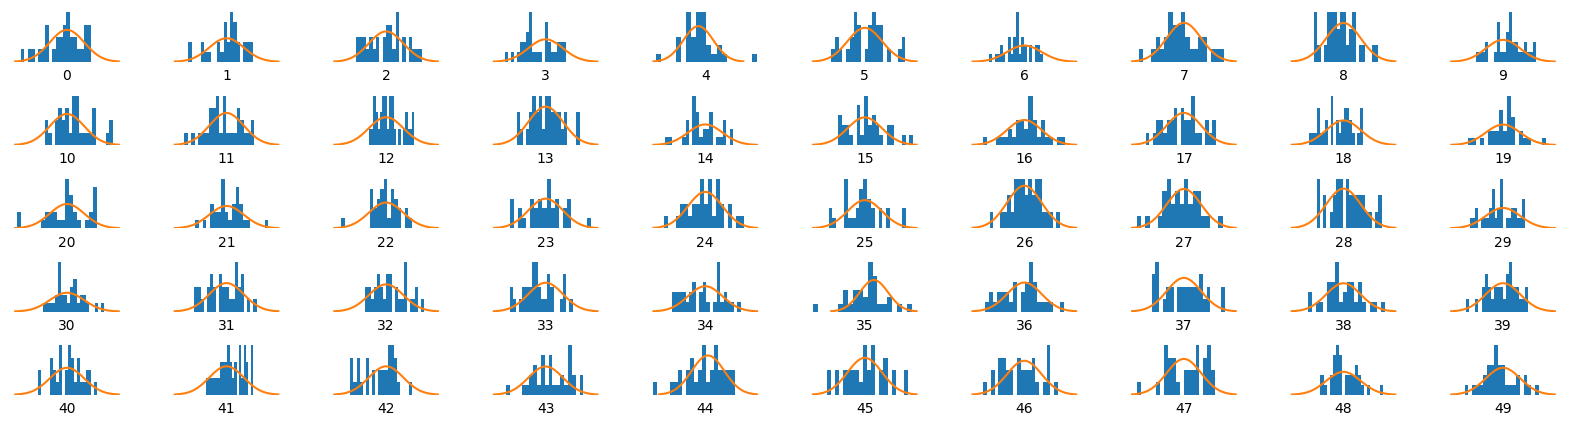

In [21]:
import matplotlib.pyplot as plt

from scipy.stats import norm

_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()